In [24]:
print("hello world")

hello world


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from scipy.stats import entropy


In [26]:
df = pd.read_csv("labeled_dataset.csv")

df["label"] = df["label"].astype(str).replace(["nan", "None", ""], "")
df["full_text"] = df["full_text"].astype(str)

df.head()


,from,full_text,label
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,Request for Email Data Contribution – Research...,Misc
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,Re: Request for Email Data Contribution – Rese...,Misc
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,NPTEL Newsletter: IIT Madras CODE Certificate ...,Misc
3,Team at Read <support@e.read.ai>,Exclusive Education Pricing Just for You! Read...,Misc
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,"Reg. Submission of SGP- Weekly reports s, Kind...",Administrative


In [27]:
labeled_df = df[df["label"] != ""].reset_index(drop=True)
unlabeled_df = df[df["label"] == ""].reset_index(drop=True)

print("Labeled:", len(labeled_df))
print("Unlabeled:", len(unlabeled_df))


Labeled: 524
Unlabeled: 1015


In [18]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_labeled = model.encode(labeled_df["full_text"].tolist(), convert_to_numpy=True)
y_labeled = labeled_df["label"].tolist()

X_unlabeled = model.encode(unlabeled_df["full_text"].tolist(), convert_to_numpy=True)


In [5]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_labeled, y_labeled)

print("Classifier trained on", len(labeled_df), "samples")


Classifier trained on 495 samples


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.20, stratify=y_labeled
)

clf_test = LogisticRegression(max_iter=2000)
clf_test.fit(X_train, y_train)

pred = clf_test.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("\n", classification_report(y_test, pred))


Accuracy: 0.7479674796747967

                 precision    recall  f1-score   support

Administrative       0.57      0.60      0.59        20
    Assignment       0.00      0.00      0.00         3
         Event       0.75      0.53      0.62        17
          Exam       0.50      0.20      0.29         5
       Lecture       0.50      0.60      0.55         5
          Misc       0.81      0.95      0.88        64
          Test       0.86      0.86      0.86         7
        Urgent       0.00      0.00      0.00         2

      accuracy                           0.75       123
     macro avg       0.50      0.47      0.47       123
  weighted avg       0.71      0.75      0.72       123



c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

In [20]:
probs = clf.predict_proba(X_unlabeled)
classes = clf.classes_


In [8]:
least_confidence = 1 - probs.max(axis=1)
margin = -np.partition(probs, -2, axis=1)[:, -1] + np.partition(probs, -2, axis=1)[:, -2]
ent = entropy(probs.T)


In [9]:
uncertainty_df = unlabeled_df.copy()
uncertainty_df["least_confidence"] = least_confidence
uncertainty_df["margin"] = margin
uncertainty_df["entropy"] = ent

uncertainty_df.sort_values("least_confidence", ascending=False).head()


,from,full_text,label,least_confidence,margin,entropy
383,"""Aishwariya Budhrani (Classroom)"" <no-reply@cl...","New announcement: ""s, Please find below form…""...",,0.822090,-0.008769,2.034777
862,"""Mohini Darji (Classroom)"" <no-reply@classroom...","New announcement: ""Dear all, kindly upload the...",,0.820594,-0.013771,2.002618
280,Priyanka Padhiyar <priyankapadhiyar.dcs@charus...,Re: Google classroom link for CSE209: Programm...,,0.817640,-0.012486,1.982157
947,"""Mohini Darji (Classroom)"" <no-reply@classroom...","New announcement: ""UNIT TEST-2 --Syllabus"" Not...",,0.812738,-0.001932,1.951165
1032,"""Pranjal Bhatt (Classroom)"" <no-reply@classroo...","New announcement: ""s, Kindly find the…"" Notifi...",,0.812325,-0.010553,1.980019


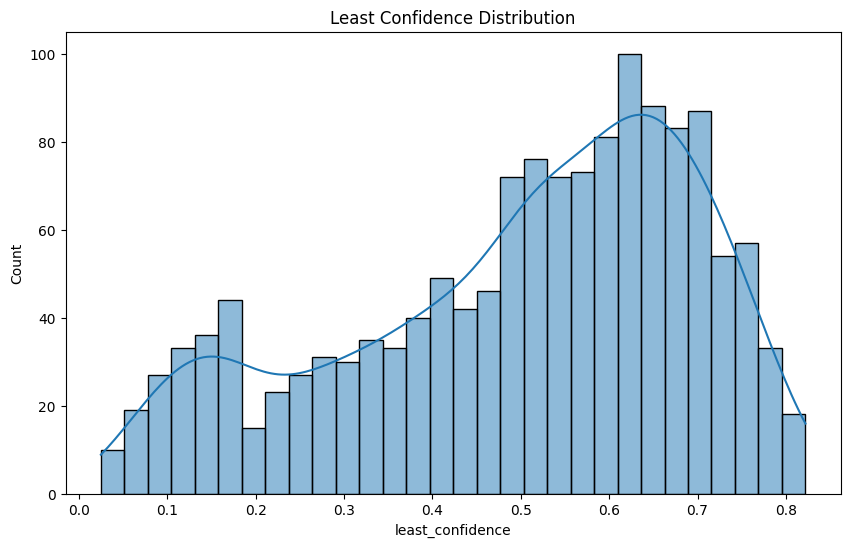

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(uncertainty_df["least_confidence"], bins=30, kde=True)
plt.title("Least Confidence Distribution")
plt.show()


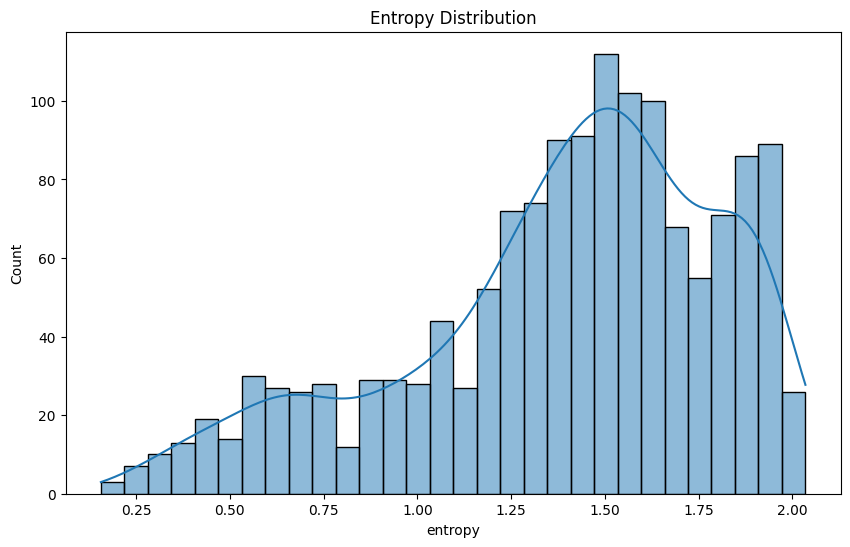

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(uncertainty_df["entropy"], bins=30, kde=True)
plt.title("Entropy Distribution")
plt.show()


In [12]:
K = 50  # you can adjust to 25/50/100

top_k = uncertainty_df.sort_values("least_confidence", ascending=False).head(K)
top_k.shape


(50, 6)

In [22]:
top_k.head()

,from,full_text,label,least_confidence,margin,entropy
383,"""Aishwariya Budhrani (Classroom)"" <no-reply@cl...","New announcement: ""s, Please find below form…""...",,0.822090,-0.008769,2.034777
862,"""Mohini Darji (Classroom)"" <no-reply@classroom...","New announcement: ""Dear all, kindly upload the...",,0.820594,-0.013771,2.002618
280,Priyanka Padhiyar <priyankapadhiyar.dcs@charus...,Re: Google classroom link for CSE209: Programm...,,0.817640,-0.012486,1.982157
947,"""Mohini Darji (Classroom)"" <no-reply@classroom...","New announcement: ""UNIT TEST-2 --Syllabus"" Not...",,0.812738,-0.001932,1.951165
1032,"""Pranjal Bhatt (Classroom)"" <no-reply@classroo...","New announcement: ""s, Kindly find the…"" Notifi...",,0.812325,-0.010553,1.980019


In [23]:
top_k.to_csv("active_learning_batch.csv", index=False)
print("Saved active_learning_batch.csv — Ready for labeling!")


Saved active_learning_batch.csv — Ready for labeling!
